In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_column(df, column, color):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Ano'], df[column], color=color)
    plt.xlabel('Ano')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.grid(True)
    plt.show()

In [3]:
df = pd.read_csv('pib_parana.csv')
df

,Ano,Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado
0,1985,2.814587e-02,7.096056e+06,10.928652,8.744574e+07
1,1986,7.587394e-02,1.030946e+07,11.165515,9.019234e+07
2,1987,2.409708e-01,1.009994e+07,12.917714,1.053171e+08
3,1988,1.733755e+00,1.275058e+07,12.821521,1.054765e+08
4,1989,2.668073e+01,1.626412e+07,13.111837,1.101532e+08
5,1990,7.327900e+02,1.119219e+07,12.993190,1.100697e+08
6,1991,3.541521e+03,1.004416e+07,12.884538,1.100342e+08
7,1992,3.757083e+04,1.025940e+07,12.613428,1.098885e+08
8,1993,8.344589e+05,1.244160e+07,13.700438,1.208850e+08
9,1994,2.130382e+07,1.588727e+07,14.277257,1.275492e+08


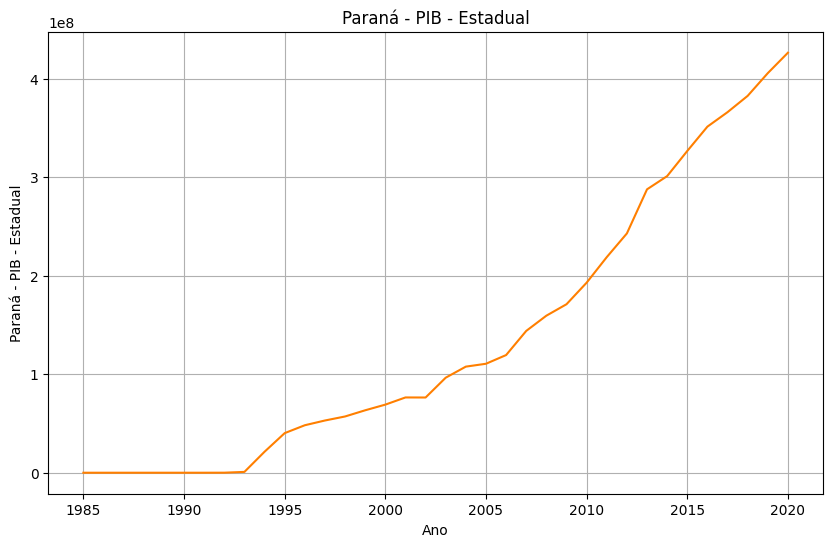

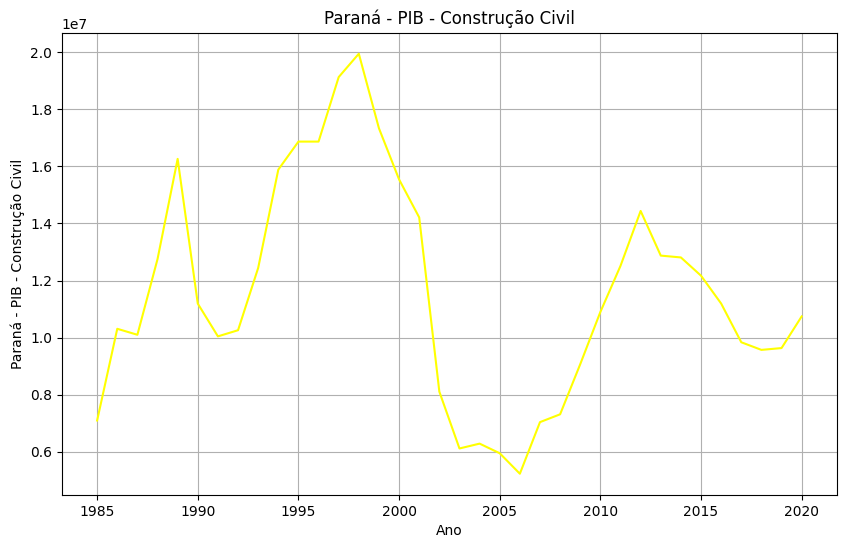

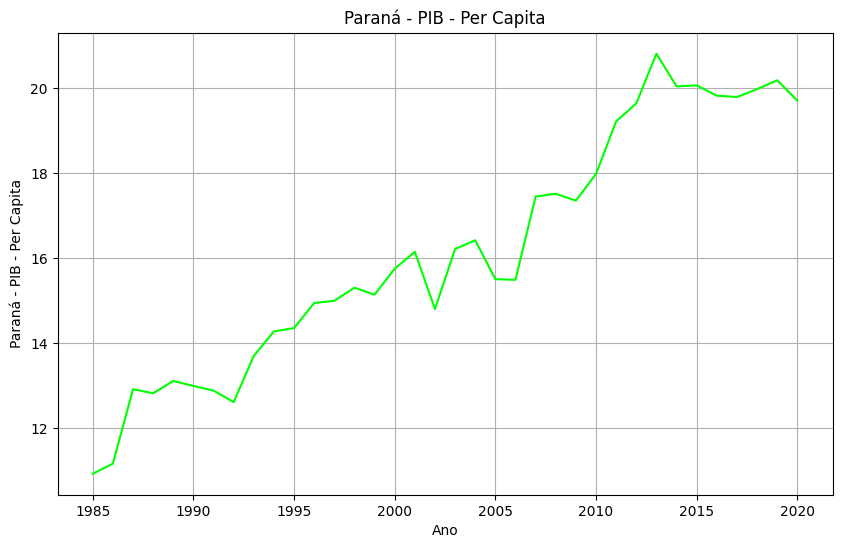

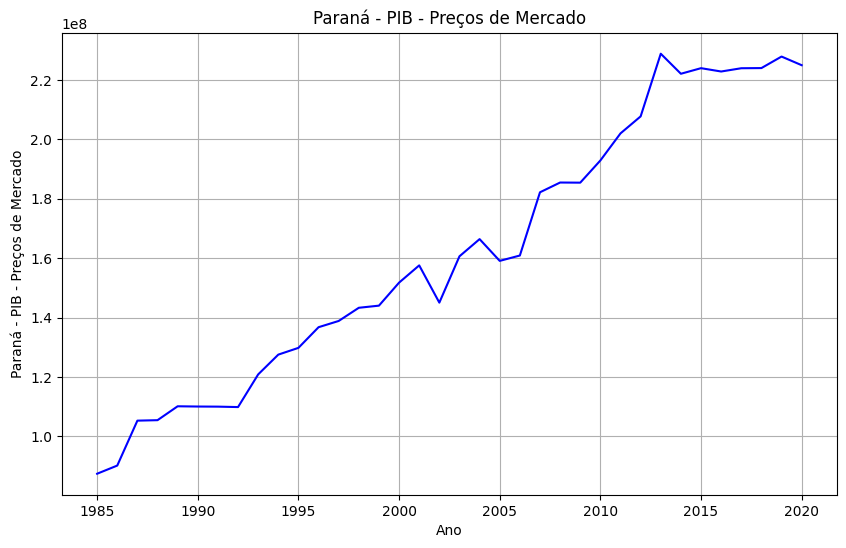

In [4]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF']
for i, column in enumerate(df.columns):
    if i > 0:
        plot_column(df, column, color=colors[i])